In [39]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Clone the dataset repository
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 39.04 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Updating files: 100% (60001/60001), done.


In [40]:
TRAINING_DIRECTORY = 'CIFAR-10-images/test'
CATEGORIES_LIST = os.listdir(TRAINING_DIRECTORY)
print(CATEGORIES_LIST)

['horse', 'ship', 'frog', 'cat', 'automobile', 'dog', 'bird', 'deer', 'truck', 'airplane']


In [42]:
TRAINING_DATA = []
for category in CATEGORIES_LIST:
    path = os.path.join(TRAINING_DIRECTORY, category)
    class_number = CATEGORIES_LIST.index(category)
    for image_file in tqdm(os.listdir(path)):
        image_array = cv2.imread(os.path.join(path, image_file), cv2.IMREAD_GRAYSCALE)
        TRAINING_DATA.append([image_array, class_number])

# Shuffle the training data
random.shuffle(TRAINING_DATA)

100%|██████████| 1000/1000 [00:00<00:00, 22535.36it/s]


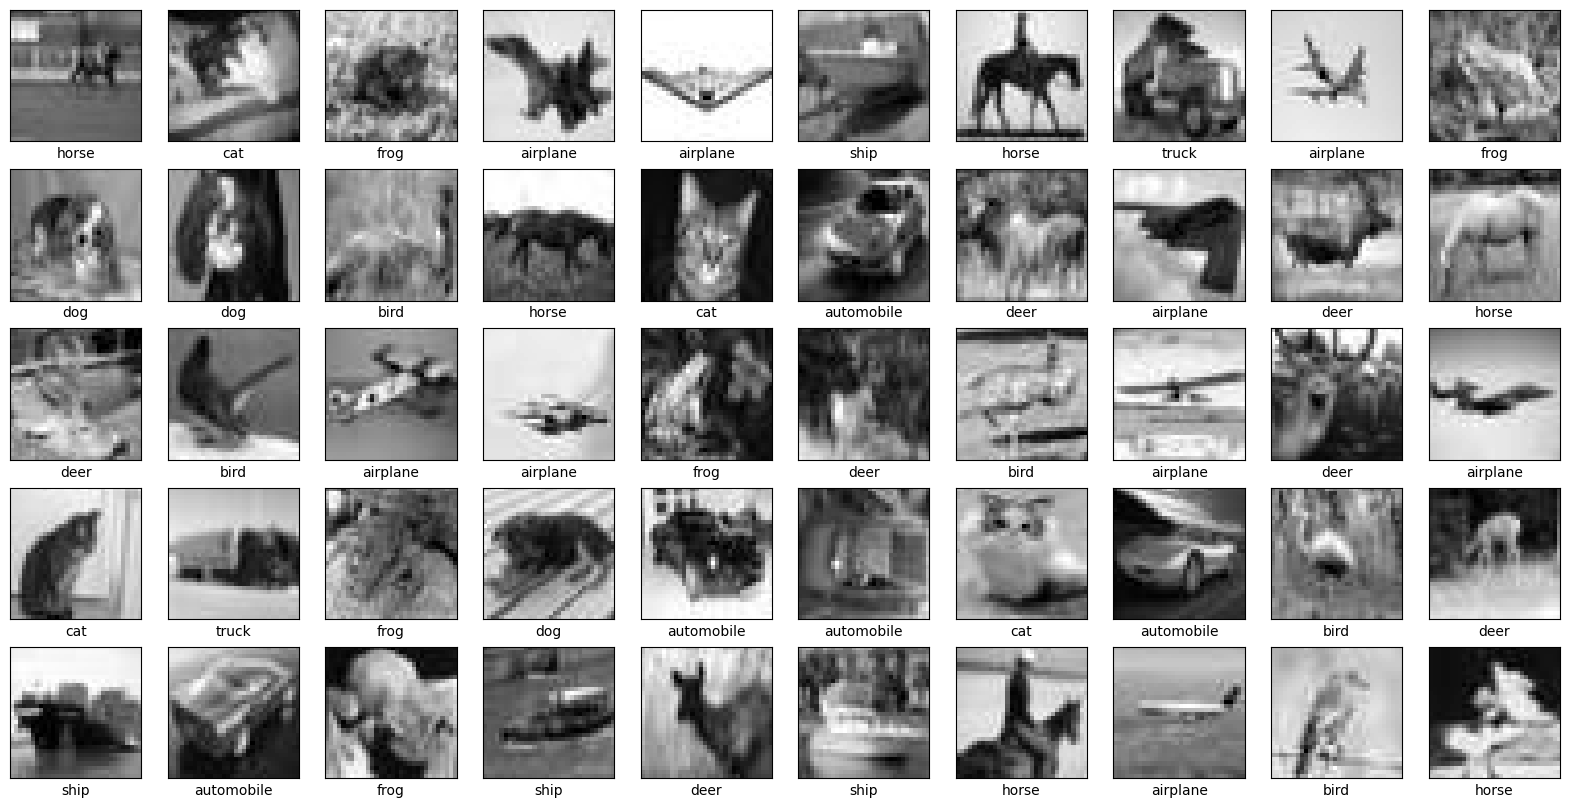

In [43]:
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(TRAINING_DATA[i][0], cmap='gray')
    plt.xlabel(CATEGORIES_LIST[TRAINING_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:
        break
plt.show()

In [44]:
fold_size = 10
folds = [TRAINING_DATA[i:i+fold_size] for i in range(0, len(TRAINING_DATA), fold_size)]


In [45]:
def plot_accuracies(fold_num, k_values, accuracy_data):
    best_result = [0, 0]
    for k in k_values:
        accuracy_values = accuracy_data[k]
        if best_result[1] < max(accuracy_values):
            best_result[0] = k
            best_result[1] = max(accuracy_values)
        plt.scatter([k] * len(accuracy_values), accuracy_values)

    accuracies_mean = np.array([np.mean(values) for key, values in sorted(accuracy_data.items())])
    accuracies_std = np.array([np.std(values) for key, values in sorted(accuracy_data.items())])
    plt.errorbar(k_values, accuracies_mean, yerr=accuracies_std)
    plt.title(f"Cross-validation   fold={fold_num}   K={best_result[0]}   Accuracy = {best_result[1]}")
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()


In [46]:
k_values = [1, 3, 5, 7, 9]
k_values_error_l1 = {k: [] for k in k_values}
k_values_error_l2 = {k: [] for k in k_values}

In [47]:
for i in range(5):
    # Define training and validation sets
    training_set = [fold for j, fold in enumerate(folds) if j != i]
    validation_set = folds[i]

    l1_accuracies = []
    l2_accuracies = []

    for k in k_values:
        l1_correct = 0
        l2_correct = 0
        total = 0

        for validation_data in tqdm(validation_set):
            v_img = validation_data[0]
            v_label = validation_data[1]
            l1_scores = []
            l2_scores = []

            for fold in training_set:
                for training_data in fold:
                    t_img = training_data[0]
                    t_label = training_data[1]

                    l1_dist = np.sum(np.abs(t_img - v_img))
                    l1_scores.append((l1_dist, t_label))

                    l2_dist = np.sqrt(np.sum((t_img - v_img) ** 2))
                    l2_scores.append((l2_dist, t_label))

            sorted_l1_scores = sorted(l1_scores, key=lambda x: x[0])[:k]
            l1_neighbors = [s[1] for s in sorted_l1_scores]
            l1_prediction = max(set(l1_neighbors), key=l1_neighbors.count)

            sorted_l2_scores = sorted(l2_scores, key=lambda x: x[0])[:k]
            l2_neighbors = [s[1] for s in sorted_l2_scores]
            l2_prediction = max(set(l2_neighbors), key=l2_neighbors.count)

            if l1_prediction == v_label:
                l1_correct += 1
            if l2_prediction == v_label:
                l2_correct += 1
            total += 1

        l1_accuracy = l1_correct / total
        l1_accuracies.append(l1_accuracy)
        k_values_error_l1[k].append(l1_accuracy)

        l2_accuracy = l2_correct / total
        l2_accuracies.append(l2_accuracy)
        k_values_error_l2[k].append(l2_accuracy)

        print("Fold {}, k = {}, L1 accuracy = {:.2f}%, L2 accuracy = {:.2f}%".format(i, k, l1_accuracy * 100, l2_accuracy * 100))

    min_l1_accuracy = min(l1_accuracies)
    max_l1_accuracy = max(l1_accuracies)
    midpoint_l1_accuracy = (min_l1_accuracy + max_l1_accuracy) / 2

    min_l2_accuracy = min(l2_accuracies)
    max_l2_accuracy = max(l2_accuracies)
    midpoint_l2_accuracy = (min_l2_accuracy + max_l2_accuracy) / 2

100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Fold 0, k = 1, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Fold 0, k = 3, L1 accuracy = 40.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Fold 0, k = 5, L1 accuracy = 30.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Fold 0, k = 7, L1 accuracy = 30.00%, L2 accuracy = 40.00%


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Fold 0, k = 9, L1 accuracy = 20.00%, L2 accuracy = 40.00%


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Fold 1, k = 1, L1 accuracy = 20.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


Fold 1, k = 3, L1 accuracy = 10.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Fold 1, k = 5, L1 accuracy = 10.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Fold 1, k = 7, L1 accuracy = 10.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Fold 1, k = 9, L1 accuracy = 10.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Fold 2, k = 1, L1 accuracy = 20.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Fold 2, k = 3, L1 accuracy = 40.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Fold 2, k = 5, L1 accuracy = 50.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Fold 2, k = 7, L1 accuracy = 60.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Fold 2, k = 9, L1 accuracy = 40.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Fold 3, k = 1, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Fold 3, k = 3, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Fold 3, k = 5, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Fold 3, k = 7, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Fold 3, k = 9, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Fold 4, k = 1, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Fold 4, k = 3, L1 accuracy = 20.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Fold 4, k = 5, L1 accuracy = 20.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Fold 4, k = 7, L1 accuracy = 20.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

Fold 4, k = 9, L1 accuracy = 20.00%, L2 accuracy = 0.00%


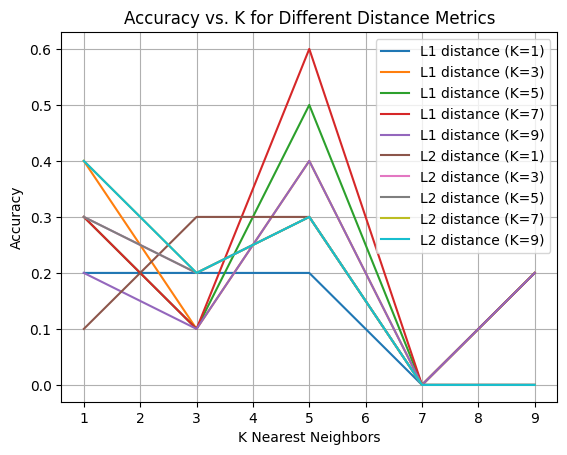

In [50]:
plt.plot(k_values, k_values_error_l1[1], label='L1 distance (K=1)')
plt.plot(k_values, k_values_error_l1[3], label='L1 distance (K=3)')
plt.plot(k_values, k_values_error_l1[5], label='L1 distance (K=5)')
plt.plot(k_values, k_values_error_l1[7], label='L1 distance (K=7)')
plt.plot(k_values, k_values_error_l1[9], label='L1 distance (K=9)')

plt.plot(k_values, k_values_error_l2[1], label='L2 distance (K=1)')
plt.plot(k_values, k_values_error_l2[3], label='L2 distance (K=3)')
plt.plot(k_values, k_values_error_l2[5], label='L2 distance (K=5)')
plt.plot(k_values, k_values_error_l2[7], label='L2 distance (K=7)')
plt.plot(k_values, k_values_error_l2[9], label='L2 distance (K=9)')

plt.xlabel('K Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K for Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()

Code Overview
The provided code is an implementation of a k-Nearest Neighbors (k-NN) classifier applied to image classification using the CIFAR-10 dataset. It involves several key components:

Data Loading and Preprocessing: The code starts by cloning a GitHub repository to obtain the CIFAR-10 dataset. It loads grayscale images from the dataset, where each image belongs to one of the ten predefined categories. The data is divided into training and testing sets.

Cross-Validation: The training data is split into five folds for cross-validation. In each fold, a different subset of data is used as the validation set, while the others form the training set.

K-Nearest Neighbors Algorithm: For each fold and for different values of k, the code calculates the accuracy of k-NN classification using both L1 (Manhattan) and L2 (Euclidean) distances. It iterates through the validation set, calculates distances between a validation image and all training images, selects the k nearest neighbors, and assigns the class label by majority voting.

Accuracy Visualization: The code plots accuracy against k for both L1 and L2 distance metrics to help determine the optimal k value.

Discussion Points
Data Preparation: The code loads and preprocesses data efficiently. However, it uses grayscale images, which may lose valuable color information. Depending on the use case, you might consider using the original CIFAR-10 images in color.

Cross-Validation: Using cross-validation is a good practice to evaluate the model's performance and reduce the risk of overfitting. The code correctly divides the data into folds and tests different k values.

K-NN Algorithm: The code effectively implements the k-NN algorithm with both L1 and L2 distances. However, k-NN can be computationally expensive for large datasets or high-dimensional data. You may explore dimensionality reduction techniques to improve efficiency.

Hyperparameter Tuning: The code includes a visualization of accuracy vs. k, which is essential for hyperparameter tuning. However, it could be beneficial to include a more systematic search for the best k value, such as grid search or random search.

Visualization: The code provides visualizations of sample images and accuracy results, which is useful for understanding the data and model performance.

Code Modularity: The code could benefit from more modular functions to enhance readability and reusability. For instance, defining separate functions for data loading, k-NN classification, and visualization can make the code more maintainable.

Code Comments and Documentation: Adding comments and documentation to the code would improve its readability and help others understand the purpose of each section and variable.

Additional Metrics: While accuracy is a common metric for classification, you might also consider evaluating the model using other metrics such as precision, recall, F1-score, or confusion matrices to gain a more comprehensive understanding of its performance.

Efficiency Considerations: For larger datasets, optimizing the k-NN algorithm's performance by utilizing data structures like KD-trees or Ball Trees could significantly speed up the process.

Consider Parallelization: If applicable, parallelizing the k-NN computation could further improve the code's execution time.

In summary, the provided code serves as a good starting point for implementing a k-NN classifier for image classification. It follows best practices such as cross-validation and hyperparameter tuning, but there's room for improvement in terms of code organization and efficiency, depending on the specific use case and dataset size.